# Experiment with Florence-2 model
- Source of example: https://huggingface.co/microsoft/Florence-2-large/blob/main/sample_inference.ipynb

In [77]:
import requests
import torch
from PIL import Image, ImageDraw, ImageFont
import random
import numpy as np
from transformers import AutoProcessor, AutoModelForCausalLM
import copy
import requests
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pprint import pprint
from pathlib import Path
%matplotlib inline

In [24]:
colormap = [
    "blue",
    "orange",
    "green",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
    "red",
    "lime",
    "indigo",
    "violet",
    "aqua",
    "magenta",
    "coral",
    "gold",
    "tan",
    "skyblue",
]

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

cuda:0


In [3]:
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32
print(torch_dtype)

torch.float16


In [4]:
model_id = 'microsoft/Florence-2-large'
model = AutoModelForCausalLM.from_pretrained(
    model_id, torch_dtype=torch_dtype, trust_remote_code=True
).to(device)
processor = AutoProcessor.from_pretrained(
    model_id, trust_remote_code=True
)

c:\Users\steve\OneDrive\Documents\GitHub\mk8dx-lap-time-tracker\.venv\lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


pytorch_model.bin:   0%|          | 0.00/1.56G [00:00<?, ?B/s]

c:\Users\steve\OneDrive\Documents\GitHub\mk8dx-lap-time-tracker\.venv\lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\steve\.cache\huggingface\hub\models--microsoft--Florence-2-large. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


generation_config.json:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

processing_florence2.py:   0%|          | 0.00/48.7k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large:
- processing_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


tokenizer_config.json:   0%|          | 0.00/34.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.10M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [5]:
prompt = "<OD>"

url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/car.jpg?download=true"
image = Image.open(requests.get(url, stream=True).raw)

In [6]:
inputs = processor(text=prompt, images=image, return_tensors="pt").to(
    device, torch_dtype
)

In [7]:
generated_ids = model.generate(
    input_ids=inputs["input_ids"],
    pixel_values=inputs["pixel_values"],
    max_new_tokens=4096,
    num_beams=3,
    do_sample=False,
)

In [8]:
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]

In [9]:
parsed_answer = processor.post_process_generation(
    generated_text, task="<OD>", image_size=(image.width, image.height)
)

print(parsed_answer)

{'<OD>': {'bboxes': [[33.599998474121094, 160.55999755859375, 596.7999877929688, 371.7599792480469], [271.67999267578125, 242.1599884033203, 302.3999938964844, 246.95999145507812]], 'labels': ['car', 'door handle']}}


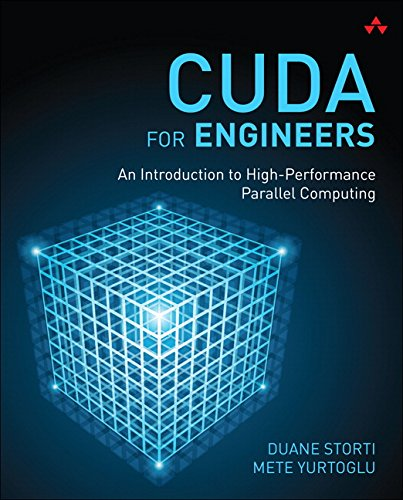

In [10]:
url = "http://ecx.images-amazon.com/images/I/51UUzBDAMsL.jpg?download=true"
image = Image.open(requests.get(url, stream=True).raw).convert("RGB")
image

In [54]:
def run_example(task_prompt: str, image_file: Path, text_input: str = None) -> str:
    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input

    image = Image.open(image_file).convert("RGB")
    inputs = processor(text=prompt, images=image, return_tensors="pt").to(
        "cuda", torch.float16
    )

    generated_ids = model.generate(
        input_ids=inputs["input_ids"].cuda(),
        pixel_values=inputs["pixel_values"].cuda(),
        max_new_tokens=1024,
        early_stopping=False,
        do_sample=False,
        num_beams=3,
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(
        generated_text, task=task_prompt, image_size=(image.width, image.height)
    )

    return parsed_answer

In [16]:
def plot_bbox(image, data):
    # Create a figure and axes
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(image)

    # Plot each bounding box
    for bbox, label in zip(data["bboxes"], data["labels"]):
        # Unpack the bounding box coordinates
        x1, y1, x2, y2 = bbox
        # Create a Rectangle patch
        rect = patches.Rectangle(
            (x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor="r", facecolor="none"
        )
        # Add the rectangle to the Axes
        ax.add_patch(rect)
        # Annotate the label
        plt.text(
            x1,
            y1,
            label,
            color="white",
            fontsize=8,
            bbox=dict(facecolor="red", alpha=0.5),
        )

    # Remove the axis ticks and labels
    ax.axis("off")

    # Show the plot
    plt.show()

In [17]:
task_prompt = "<OCR>"
run_example(task_prompt)

{'<OCR>': 'CUDA\nFOR ENGINEERS\nAn Introduction to High-Performance\nParallel Computing\nDUANE STORTI\nMETE YURTOGLU\n'}

In [19]:
task_prompt = "<OCR_WITH_REGION>"
results = run_example(task_prompt)
pprint(results)

{'<OCR_WITH_REGION>': {'labels': ['</s>CUDA',
                                  'FOR ENGINEERS',
                                  'An Introduction to High-Performance',
                                  'Parallel Computing',
                                  'DUANE STORTI',
                                  'METE YURTOGLU'],
                       'quad_boxes': [[167.44650268554688,
                                       50.25,
                                       374.9914855957031,
                                       50.25,
                                       374.9914855957031,
                                       114.25,
                                       167.44650268554688,
                                       114.25],
                                      [144.8784942626953,
                                       121.25,
                                       374.9914855957031,
                                       120.25,
                                       37

In [20]:
def draw_ocr_bboxes(image, prediction, scale=1):
    draw = ImageDraw.Draw(image)
    bboxes, labels = prediction["quad_boxes"], prediction["labels"]
    for box, label in zip(bboxes, labels):
        color = random.choice(colormap)
        new_box = (np.array(box) * scale).tolist()
        draw.polygon(new_box, width=3, outline=color)
        draw.text(
            (new_box[0] + 8, new_box[1] + 2),
            "{}".format(label),
            align="right",
            fill=color,
        )

    display(image)

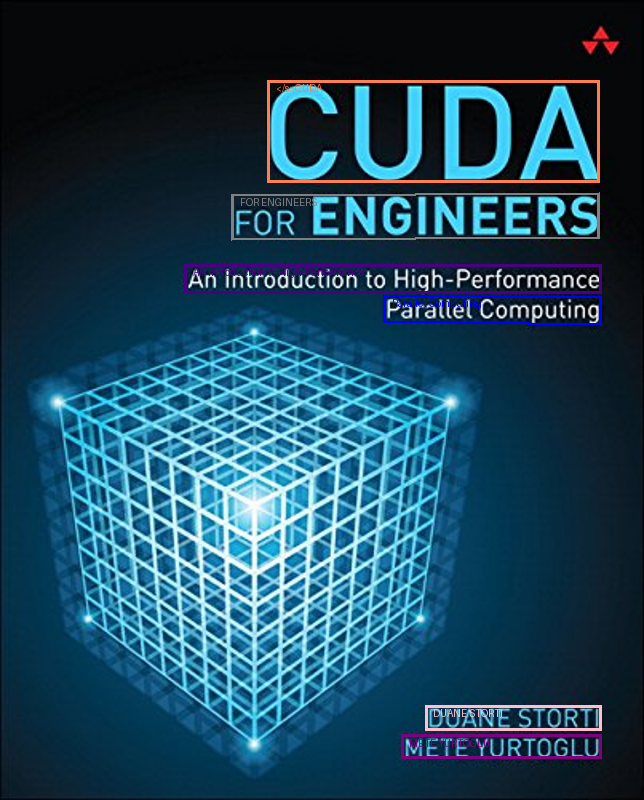

In [25]:
output_image = copy.deepcopy(image)
w, h = output_image.size
scale = 800 / max(w, h)
new_output_image = output_image.resize((int(w * scale), int(h * scale)))
draw_ocr_bboxes(new_output_image, results["<OCR_WITH_REGION>"], scale=scale)

## Test with MK8DX screenshot

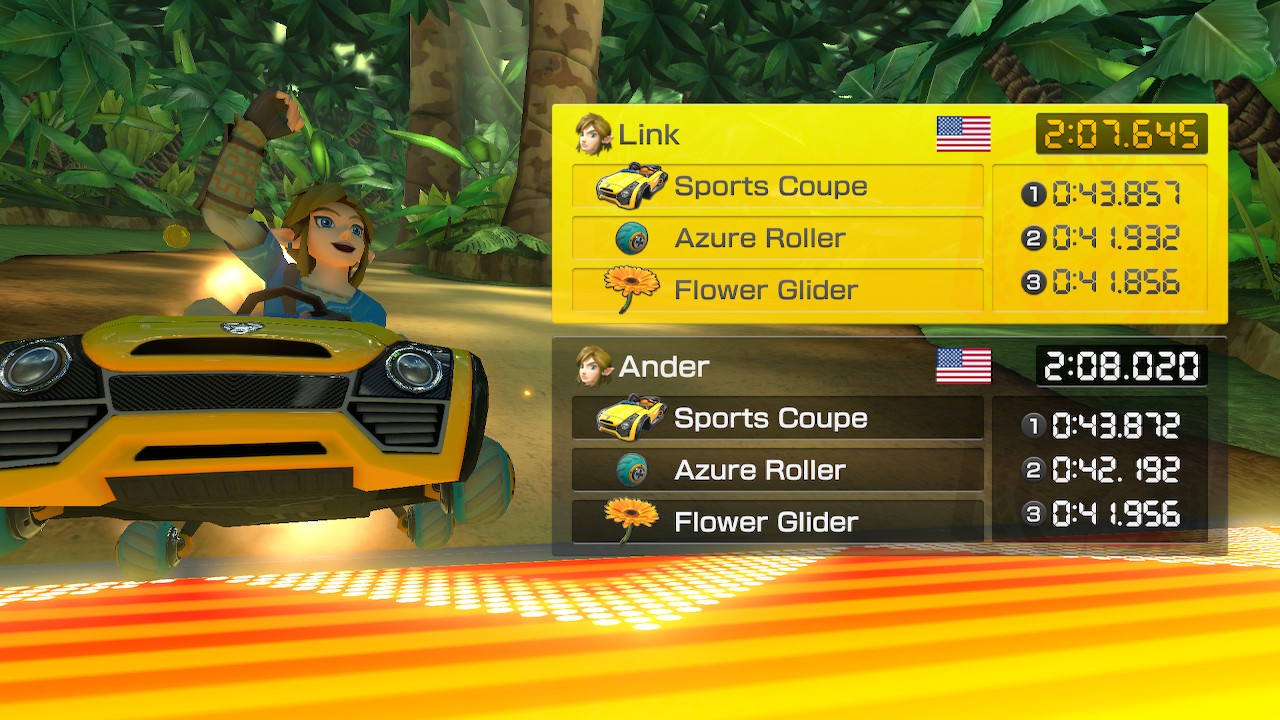

In [27]:
image = Image.open("data/test_images/2023070318441000_s.jpg").convert("RGB")
image

In [28]:
task_prompt = "<OCR_WITH_REGION>"
results = run_example(task_prompt)
pprint(results)

{'<OCR_WITH_REGION>': {'labels': ['</s>Link',
                                  '2:07.645',
                                  'Sports Coupe',
                                  '1 0:43.857',
                                  'Azure Roller',
                                  '2 0:04.1932',
                                  'Flower Glider',
                                  '3 0:4.1856',
                                  'Ander',
                                  '2:08.020',
                                  'Sports Couple',
                                  '1 0.48.872',
                                  'Azure Roller',
                                  '2 0.42.92',
                                  'Flower Glder',
                                  '3 0.4.1956'],
                       'quad_boxes': [[615.0399780273438,
                                       121.32000732421875,
                                       680.3200073242188,
                                       121.3200073242

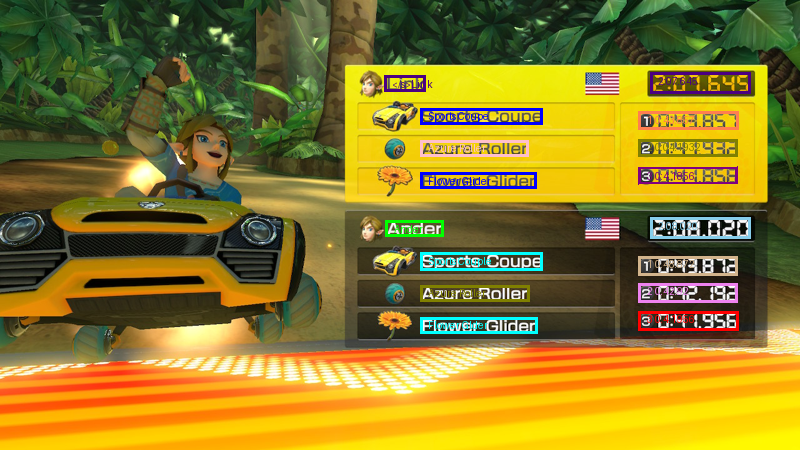

In [29]:
output_image = copy.deepcopy(image)
w, h = output_image.size
scale = 800 / max(w, h)
new_output_image = output_image.resize((int(w * scale), int(h * scale)))
draw_ocr_bboxes(new_output_image, results["<OCR_WITH_REGION>"], scale=scale)

In [34]:
task_prompt = "<OPEN_VOCABULARY_DETECTION>"
results = run_example(task_prompt, text_input="a national flag")
pprint(results)

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[931.199951171875,
                                             343.08001708984375,
                                             995.199951171875,
                                             389.8800048828125],
                                            [931.199951171875,
                                             111.96000671386719,
                                             995.199951171875,
                                             157.32000732421875]],
                                 'bboxes_labels': ['a national flag',
                                                   'a nationalflag'],
                                 'polygons': [],
                                 'polygons_labels': []}}


In [35]:
def convert_to_od_format(data):
    """
    Converts a dictionary with 'bboxes' and 'bboxes_labels' into a dictionary with separate 'bboxes' and 'labels' keys.

    Parameters:
    - data: The input dictionary with 'bboxes', 'bboxes_labels', 'polygons', and 'polygons_labels' keys.

    Returns:
    - A dictionary with 'bboxes' and 'labels' keys formatted for object detection results.
    """
    # Extract bounding boxes and labels
    bboxes = data.get("bboxes", [])
    labels = data.get("bboxes_labels", [])

    # Construct the output format
    od_results = {"bboxes": bboxes, "labels": labels}

    return od_results

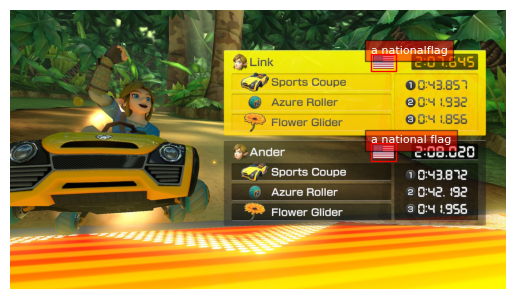

In [36]:
bbox_results = convert_to_od_format(results["<OPEN_VOCABULARY_DETECTION>"])
plot_bbox(image, bbox_results)

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[301.44000244140625,
                                             199.8000030517578,
                                             373.1199951171875,
                                             273.2400207519531]],
                                 'bboxes_labels': ['a Mario Kart 8 Deluxe '
                                                   'character face'],
                                 'polygons': [],
                                 'polygons_labels': []}}


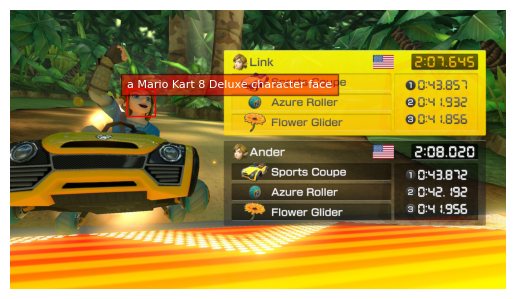

In [37]:
task_prompt = "<OPEN_VOCABULARY_DETECTION>"
results = run_example(task_prompt, text_input="a Mario Kart 8 Deluxe character face")
pprint(results)
bbox_results = convert_to_od_format(results["<OPEN_VOCABULARY_DETECTION>"])
plot_bbox(image, bbox_results)

In [75]:
def ocr_image(
    image_file: Path,
    framework: str,
    kind: int = None,
    endpoint_name: str = None,
    endpoint_version: str = None,
) -> dict:
    """
    Given an image Path (which may be cropped and transformed)
    and a framework, return the text ocr'ed from that box in a
    dictionary where key is a field name and value is a string.

    box = a list of integers representing pixels: [x1, y1, x2, y2]
    framework = a string: 'mindee' or 'ocrs'
    """

    if framework == "mindee":
        mindee_client = Client(api_key=os.getenv("MINDEE_API_KEY"))
        input_doc = mindee_client.source_from_path(image_file)
        endpoint = mindee_client.create_endpoint(
            account_name="polimath",
            endpoint_name=endpoint_name,
            version=endpoint_version,
        )
        result: AsyncPredictResponse = mindee_client.enqueue_and_parse(
            product.GeneratedV1, input_doc, endpoint=endpoint
        )
        del mindee_client
        return {
            k: v.value for k, v in result.document.inference.prediction.fields.items()
        }
    elif framework == "openai":
        openai_client = openai.OpenAI(api_key=openai_api_key)
        base64_image = encode_image_for_api_call(image_file)
        openai_response = openai_client.beta.chat.completions.parse(
            model="gpt-4o-mini",
            messages=[
                {
                    "role": "user",
                    "content": [
                        {"type": "text", "text": prompts["openai"][kind]},
                        {
                            "type": "image_url",
                            "image_url": {
                                "url": f"data:image/jpeg;base64,{base64_image}"
                            },
                        },
                    ],
                }
            ],
            max_tokens=300,
            response_format=eval(f"kind_{kind}_image"),
        )

        return dict(openai_response.choices[0].message.parsed)
    elif framework == "ocrs":
        ocr_result = subprocess.run(["ocrs", image_file], stdout=subprocess.PIPE)
        return {"ocr_result": ocr_result.stdout.decode("utf-8").strip()}
    elif framework == "florence":
        task_prompt = "<OCR>"
        ocr_result = run_example(task_prompt, image_file=image_file)
        return {"ocr_result": ocr_result["<OCR>"].strip()}
    else:
        return {}

In [76]:
results = ocr_image(
    image_file=Path("data/test_images/lap_time_yellow_background.jpg"),
    framework="florence",
)
pprint(results)

{'ocr_result': 'H'}
